In [149]:
import pandas as pd
import numpy as np
from matplotlib import pylab as plt
import re

In [150]:
df = pd.read_csv('./glassdoor_jobs.csv')
print(df.shape)
df.head()

(1500, 12)


,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Size,Founded,Type of ownership,Industry,Sector,Revenue
0,Data Scientist,-1,Job Overview\nA Data Scientist at ExploreLearn...,4.2,Cambium Learning Group\n4.3,Remote,1001 to 5000 Employees,2004,Company - Private,Primary & Secondary Schools,Education,$500 million to $1 billion (USD)
1,2024 University Graduate - Data Scientist,Employer Provided Salary:$83K - $153K,Our Company\n\nChanging the world through digi...,4.4,Adobe\n4.4,"San Jose, CA",10000+ Employees,1982,Company - Public,Computer Hardware Development,Information Technology,$5 to $10 billion (USD)
2,Data Scientist – Entry Level 2024,Employer Provided Salary:$71K - $133K,Introduction\nRanked by Forbes as one of the w...,3.9,IBM\n3.9,"Atlanta, GA",10000+ Employees,1911,Company - Public,Information Technology Support Services,Information Technology,$10+ billion (USD)
3,Data Scientist 2,Employer Provided Salary:$94K - $183K,The Microsoft 365 team is looking for a Data S...,4.3,Microsoft\n4.3,"Redmond, WA",10000+ Employees,1975,Company - Public,Computer Hardware Development,Information Technology,$10+ billion (USD)
4,Entry Level Data Scientist 2023/2024,$48K - $78K (Glassdoor est.),"You may not realize it, but you’ve likely used...",3.9,CPChem\n3.9,"The Woodlands, TX",1001 to 5000 Employees,2000,Company - Private,Chemical Manufacturing,Manufacturing,$10+ billion (USD)


In [151]:
# Drop duplicates revealed by EDA
df = df.drop_duplicates()
# Reduces rows from 1500
print(df.shape)

(820, 12)


In [152]:
# Find fraction of rows with missing values
print(len(df[(df == -1).any(axis=1) | (df == '-1').any(axis=1)]) / len(df))

0.3280487804878049


In [153]:
# Drop rows with missing salary estimate
df = df[df['Salary Estimate'] != '-1']
df.head(2)

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Size,Founded,Type of ownership,Industry,Sector,Revenue
1,2024 University Graduate - Data Scientist,Employer Provided Salary:$83K - $153K,Our Company\n\nChanging the world through digi...,4.4,Adobe\n4.4,"San Jose, CA",10000+ Employees,1982,Company - Public,Computer Hardware Development,Information Technology,$5 to $10 billion (USD)
2,Data Scientist – Entry Level 2024,Employer Provided Salary:$71K - $133K,Introduction\nRanked by Forbes as one of the w...,3.9,IBM\n3.9,"Atlanta, GA",10000+ Employees,1911,Company - Public,Information Technology Support Services,Information Technology,$10+ billion (USD)


In [154]:
# Fix issue where company rating appears alongside company name
df['Company Name'] = df['Company Name'].str.replace(r'\n.*', '')

# Multiple listings from same company
# But overall dataset is diverse
print(df['Company Name'].value_counts())

-1                             9
Procter & Gamble               6
INTEL                          5
TikTok                         5
JPMorgan Chase & Co            4
                              ..
US Internal Revenue Service    1
Movable Ink                    1
LinQuest Corporation           1
AllocateRite                   1
The JAAW Group                 1
Name: Company Name, Length: 553, dtype: int64


C:\Users\Crystal Water\AppData\Local\Temp\ipykernel_1608\1903115313.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Company Name'] = df['Company Name'].str.replace(r'\n.*', '')


In [155]:
# Get state from non-remote locations
df['State'] = df['Location'].apply(lambda x: 'Remote' if x == 'Remote' else (x.split(', ')[1] if ', ' in x else '-1'))
df.head(2)

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Size,Founded,Type of ownership,Industry,Sector,Revenue,State
1,2024 University Graduate - Data Scientist,Employer Provided Salary:$83K - $153K,Our Company\n\nChanging the world through digi...,4.4,Adobe,"San Jose, CA",10000+ Employees,1982,Company - Public,Computer Hardware Development,Information Technology,$5 to $10 billion (USD),CA
2,Data Scientist – Entry Level 2024,Employer Provided Salary:$71K - $133K,Introduction\nRanked by Forbes as one of the w...,3.9,IBM,"Atlanta, GA",10000+ Employees,1911,Company - Public,Information Technology Support Services,Information Technology,$10+ billion (USD),GA


In [156]:
# Analyze missing data
missing_data = {}
for col in df.columns:
  if col in ['Rating', 'Founded']:
    num_missing = df[df[col] == -1].shape[0]
  else:
    num_missing = df[df[col] == '-1'].shape[0]
  prc_missing = num_missing / df.shape[0]
  missing_data[col] = prc_missing
  print(col, prc_missing)

Job Title 0.010294117647058823
Salary Estimate 0.0
Job Description 0.008823529411764706
Rating 0.06764705882352941
Company Name 0.013235294117647059
Location 0.011764705882352941
Size 0.023529411764705882
Founded 0.17941176470588235
Type of ownership 0.023529411764705882
Industry 0.09558823529411764
Sector 0.09558823529411764
Revenue 0.023529411764705882
State 0.039705882352941174


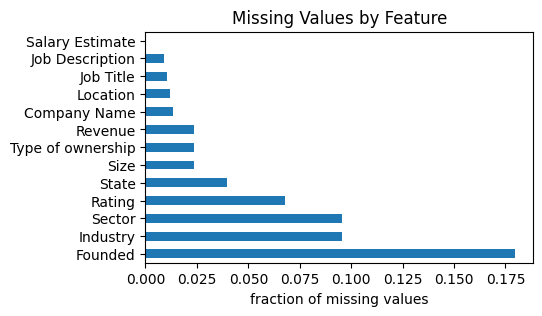

In [157]:
plt.figure(figsize=(5,3))
series_data = pd.Series(missing_data).sort_values(ascending=False)
series_data.plot.barh()
plt.xlabel('fraction of missing values')
plt.title('Missing Values by Feature')
plt.show()

### Reformat 'Salary Estimate' column:

In [158]:
# Reformat 'Salary Estimate' column

def transform_salary(salary_string):
    # Assume 40hr/week for 52 weeks/year
    hours_per_year = 40 * 52

    # Case 1: annual salary range
    annual_match = re.match(r'.*\$(\d+(?:\.\d+)?)[Kk] - \$(\d+(?:\.\d+)?)[Kk].*', salary_string)
    if annual_match:
        low = float(annual_match.group(1)) * 1000
        high = float(annual_match.group(2)) * 1000
        return low, high

    # Case 2: hourly rate range
    hourly_match = re.match(r'.*\$(\d+(?:\.\d+)?) - \$(\d+(?:\.\d+)?) Per Hour.*', salary_string)
    if hourly_match:
        low_salary = float(hourly_match.group(1)) * hours_per_year
        high_salary = float(hourly_match.group(2)) * hours_per_year
        return low_salary, high_salary

    # Case 3: single annual salary value
    single_annual_match = re.match(r'.*\$(\d+(?:\.\d+)?)[Kk].*', salary_string)
    if single_annual_match:
        salary_value = float(single_annual_match.group(1).replace('K', '')) * 1000
        return salary_value, salary_value

    # Case 4: single hourly rate value
    single_hourly_match = re.match(r'.*\$(\d+(?:\.\d+)?) Per Hour.*', salary_string)
    if single_hourly_match:
        hourly_rate = float(single_hourly_match.group(1))
        low_salary = hourly_rate * hours_per_year
        high_salary = hourly_rate * hours_per_year
        return low_salary, high_salary
    
    # Print any cases we missed
    print(salary_string)
    return None, None

df['Low_Salary'], df['High_Salary'] = zip(*df['Salary Estimate'].apply(transform_salary))
df['Avg_Salary'] = (df['Low_Salary'] + df['High_Salary']) / 2
df.head(2)

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Size,Founded,Type of ownership,Industry,Sector,Revenue,State,Low_Salary,High_Salary,Avg_Salary
1,2024 University Graduate - Data Scientist,Employer Provided Salary:$83K - $153K,Our Company\n\nChanging the world through digi...,4.4,Adobe,"San Jose, CA",10000+ Employees,1982,Company - Public,Computer Hardware Development,Information Technology,$5 to $10 billion (USD),CA,83000.0,153000.0,118000.0
2,Data Scientist – Entry Level 2024,Employer Provided Salary:$71K - $133K,Introduction\nRanked by Forbes as one of the w...,3.9,IBM,"Atlanta, GA",10000+ Employees,1911,Company - Public,Information Technology Support Services,Information Technology,$10+ billion (USD),GA,71000.0,133000.0,102000.0


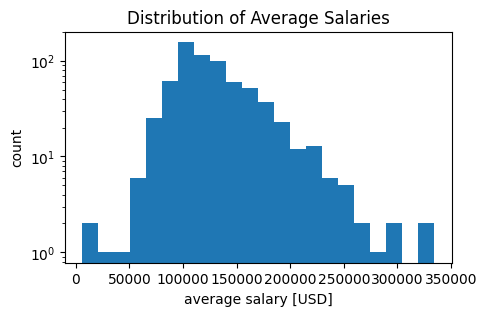

In [159]:
# Visualize distribution of average salaries
plt.figure(figsize=(5,3))
df['Avg_Salary'].plot.hist(bins=int(1+3.322*np.log(len(df)))) # Sturge's rule
plt.semilogy()
plt.xlabel('average salary [USD]')
plt.ylabel('count')
plt.title('Distribution of Average Salaries')
plt.show()

In [160]:
# Investigate outliers
df[df['High_Salary'] < 50000]

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Size,Founded,Type of ownership,Industry,Sector,Revenue,State,Low_Salary,High_Salary,Avg_Salary
105,Data Scientist 1,Employer Provided Salary:$5K - $7K,Requisition ID\nreq27082\n\nWorking Title\nDat...,3.8,University of New Mexico,"Albuquerque, NM",10000+ Employees,1889,College / University,Colleges & Universities,Education,$1 to $5 billion (USD),NM,5000.0,7000.0,6000.0
123,Data Specialist,Employer Provided Salary:$30K - $35K,"Note: While this is a fully remote position, w...",4.1,Juristat,Remote,1 to 50 Employees,2012,Company - Private,Enterprise Software & Network Solutions,Information Technology,Unknown / Non-Applicable,Remote,30000.0,35000.0,32500.0
591,DATA SCIENTIST,Employer Provided Salary:$8K - $8K,DATA SCIENTIST\n\n\nReq #:\n220683\n\nDepartme...,4.2,University of Washington,"Seattle, WA",10000+ Employees,1861,College / University,Colleges & Universities,Education,$1 to $5 billion (USD),WA,8000.0,8000.0,8000.0


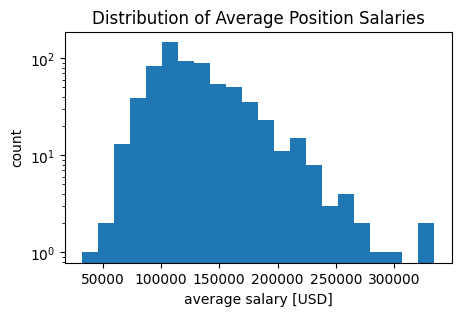

In [161]:
# The salary ranges corresponding to indices 105 and 591 are unreasonably low
# for a full-time data science position. They seem to correspond to student
# positions based on the employer name, so we will omit these from our analysis.

df.drop([105, 591], inplace=True)
df.reset_index(drop=True, inplace=True)
# Recreate histogram
plt.figure(figsize=(5,3))
df['Avg_Salary'].plot.hist(bins=int(1+3.322*np.log(len(df)))) # Sturge's rule
plt.semilogy()
plt.xlabel('average salary [USD]')
plt.ylabel('count')
plt.title('Distribution of Average Position Salaries')
plt.show()

In [162]:
# Transform 'Job Title' column

def get_job_type(title):
  if 'engineer' in title.lower():
    return 'Data Engineer'
  elif 'data scientist' in title.lower() or 'data science' in title.lower():
    return 'Data Scientist'
  elif 'analyst' in title.lower() or 'analytics' in title.lower():
    return 'Data Analyst'
  else:
    # print(title)
    return 'Other'

def get_level(title):
  if 'Entry Level' in title or 'College Graduate' in title:
    return 'Entry Level'
  elif 'Junior' in title or 'Jr. ' in title or 'Jr ' in title:
    return 'Junior'
  elif 'Senior' in title or 'Sr. ' in title or 'Sr ' in title:
    return 'Senior'
  elif 'Lead ' in title or 'Chief ' in title or 'Principal' in title:
    return 'Very Senior'
  else:
    return 'Unspecified'

df['Job Type'] = df['Job Title'].apply(get_job_type)
df['Experience Level'] = df['Job Title'].apply(get_level)
df.head(2)

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Size,Founded,Type of ownership,Industry,Sector,Revenue,State,Low_Salary,High_Salary,Avg_Salary,Job Type,Experience Level
0,2024 University Graduate - Data Scientist,Employer Provided Salary:$83K - $153K,Our Company\n\nChanging the world through digi...,4.4,Adobe,"San Jose, CA",10000+ Employees,1982,Company - Public,Computer Hardware Development,Information Technology,$5 to $10 billion (USD),CA,83000.0,153000.0,118000.0,Data Scientist,Unspecified
1,Data Scientist – Entry Level 2024,Employer Provided Salary:$71K - $133K,Introduction\nRanked by Forbes as one of the w...,3.9,IBM,"Atlanta, GA",10000+ Employees,1911,Company - Public,Information Technology Support Services,Information Technology,$10+ billion (USD),GA,71000.0,133000.0,102000.0,Data Scientist,Entry Level


C:\Users\Crystal Water\AppData\Local\Temp\ipykernel_1608\2585761945.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Job Description'] = df['Job Description'].str.replace(r'\n', ' ')


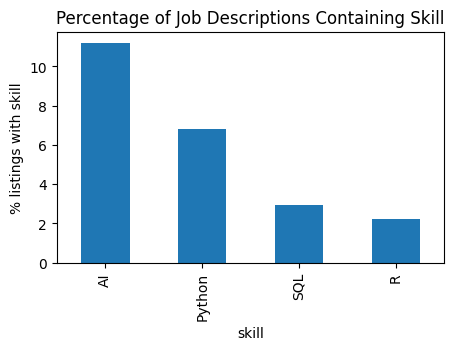

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Size,Founded,Type of ownership,Industry,...,State,Low_Salary,High_Salary,Avg_Salary,Job Type,Experience Level,Python,R,SQL,AI
0,2024 University Graduate - Data Scientist,Employer Provided Salary:$83K - $153K,Our Company Changing the world through digita...,4.4,Adobe,"San Jose, CA",10000+ Employees,1982,Company - Public,Computer Hardware Development,...,CA,83000.0,153000.0,118000.0,Data Scientist,Unspecified,1,1,1,0
1,Data Scientist – Entry Level 2024,Employer Provided Salary:$71K - $133K,Introduction Ranked by Forbes as one of the wo...,3.9,IBM,"Atlanta, GA",10000+ Employees,1911,Company - Public,Information Technology Support Services,...,GA,71000.0,133000.0,102000.0,Data Scientist,Entry Level,0,0,0,1


In [163]:
# Transform 'Job Description' column
df['Job Description'] = df['Job Description'].str.replace(r'\n', ' ')

# Common data science skills
skills_mapping = {
        "Python": ["python", "tensorflow", "pytorch", "pandas"],
        "R": ["r", "rstudio"],
        "SQL": ["sql", "postgresql", "mysql", "nosql"],
        "AI": ["ai", "artificial intelligence", "ml", "machine learning",
                                     "deep learning", "nlp", "natural language processing"],
    }

def create_skill_columns(df):
    for skill, aliases in skills_mapping.items():
        df[skill] = df['Job Description'].apply(lambda x: 1 if any(alias.lower() in x.lower().split() for alias in aliases) else 0)
    return df
df_skills = create_skill_columns(df)
percentages = df_skills[skills_mapping.keys()].mean() * 100
percentages_sorted = percentages.sort_values(ascending=False)

# # DROP OG COLUMN
# df = df.drop('Job Description')

plt.figure(figsize=(5, 3))
percentages_sorted.plot.bar()
plt.ylabel('% listings with skill')
plt.xlabel('skill')
plt.title('Percentage of Job Descriptions Containing Skill')
plt.show()

df.head(2)

<Figure size 500x300 with 0 Axes>

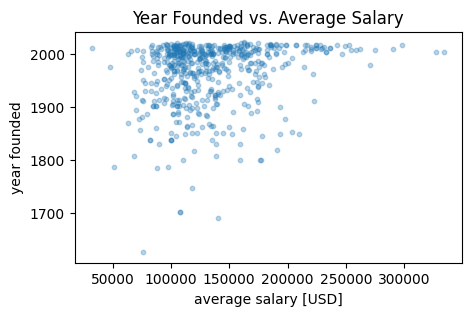

            Avg_Salary  Founded
Avg_Salary     1.00000  0.16503
Founded        0.16503  1.00000


<Figure size 500x300 with 0 Axes>

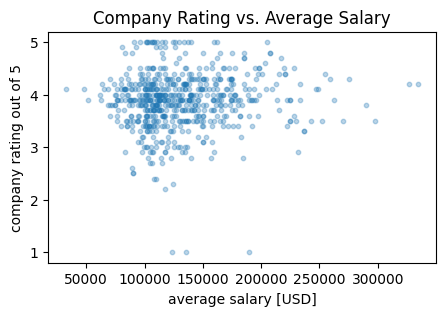

            Avg_Salary    Rating
Avg_Salary    1.000000  0.070715
Rating        0.070715  1.000000


In [164]:
# Compare continuous features to target

plt.figure(figsize=(5,3))
df[df['Founded'] != -1].plot.scatter('Avg_Salary','Founded',figsize=(5,3),alpha=0.3,s=10)
plt.xlabel('average salary [USD]')
plt.ylabel('year founded')
plt.title('Year Founded vs. Average Salary')
plt.show()
print(df[['Avg_Salary', 'Founded']].corr())

plt.figure(figsize=(5,3))
df[df['Rating'] != -1].plot.scatter('Avg_Salary','Rating',figsize=(5,3),alpha=0.3,s=10)
plt.xlabel('average salary [USD]')
plt.ylabel('company rating out of 5')
plt.title('Company Rating vs. Average Salary')
plt.show()
print(df[['Avg_Salary', 'Rating']].corr())

We note a very weak positive correlation between year founded and salary. Given
the large proportion of missing values in the 'Founded' column and its weak
correlation with the target variable, dropping the column is justified.

The company rating is also very weakly correlated with the target variable.
For this reason, it is also reasonable to drop the 'Rating' column rather
than using mean/median imputation to replace the null values.

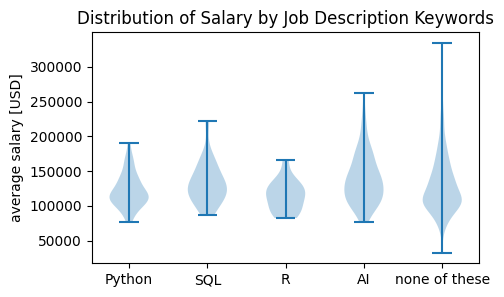

In [165]:
plt.figure(figsize=(5,3))
plt.violinplot([df[df['Python']==1]['Avg_Salary'].values,
                df[df['SQL']==1]['Avg_Salary'].values,
                df[df['R']==1]['Avg_Salary'].values,
                df[df['AI']==1]['Avg_Salary'].values,
                df[(df['Python']==0) & (df['R']==0) & (df['SQL']==0) & (df['AI']==0)]['Avg_Salary'].values])
plt.xticks([1,2,3,4,5],['Python','SQL','R', 'AI', 'none of these'])
plt.ylabel('average salary [USD]')
plt.title('Distribution of Salary by Job Description Keywords')
plt.show()

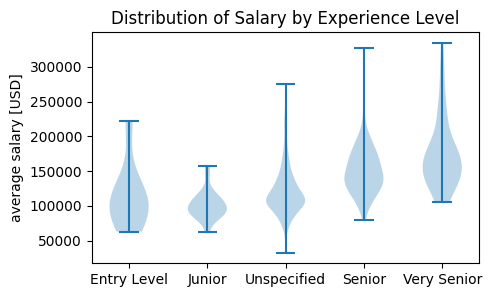

In [166]:
plt.figure(figsize=(5,3))
plt.violinplot([df[df['Experience Level']=='Entry Level']['Avg_Salary'].values,
                df[df['Experience Level']=='Junior']['Avg_Salary'].values,
                df[df['Experience Level']=='Unspecified']['Avg_Salary'].values,
                df[df['Experience Level']=='Senior']['Avg_Salary'].values,
                df[df['Experience Level']=='Very Senior']['Avg_Salary'].values
            ])
plt.xticks([1,2,3,4,5],['Entry Level','Junior','Unspecified','Senior','Very Senior'])
plt.ylabel('average salary [USD]')
plt.title('Distribution of Salary by Experience Level')
plt.show()

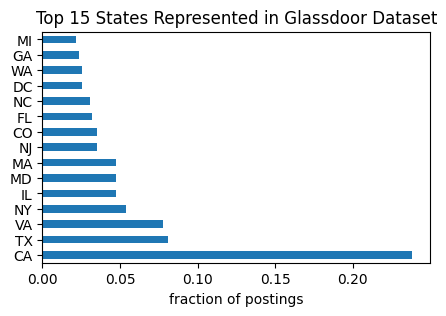

In [167]:
plt.figure(figsize=(5,3))
pd.value_counts(df[(df['State'] != '-1') & (df['State'] != 'Remote')]['State'],normalize=True).nlargest(15).plot.barh()
plt.xlabel('fraction of postings')
plt.title('Top 15 States Represented in Glassdoor Dataset')
plt.show()

In [168]:
# Let's analyze value counts for some of our categorical features
ftrs = ['Company Name', 'Location', 'Size', 'Type of ownership', 'Industry', 'Sector', 'Revenue']
for ftr in ftrs:
  print(ftr, 'value counts:')
  print(df[ftr].value_counts())
  print('')

Company Name value counts:
-1                             9
Procter & Gamble               6
INTEL                          5
TikTok                         5
JPMorgan Chase & Co            4
                              ..
US Internal Revenue Service    1
Movable Ink                    1
LinQuest Corporation           1
AllocateRite                   1
The JAAW Group                 1
Name: Company Name, Length: 551, dtype: int64

Location value counts:
Remote                    58
San Francisco, CA         33
New York, NY              28
Austin, TX                17
Boston, MA                16
                          ..
Fargo, ND                  1
Rochester, MN              1
Maryland                   1
Robbinsville, NJ           1
Cottonwood Heights, UT     1
Name: Location, Length: 251, dtype: int64

Size value counts:
10000+ Employees           237
1001 to 5000 Employees     118
1 to 50 Employees           71
51 to 200 Employees         68
201 to 500 Employees        44
5001

In [169]:
# We note that some features have both "Unknown" categories and missing values.
# Let's group those together in the same category.
df['Size'] = df['Size'].replace('Unknown', '-1')
df['Type of ownership'] = df['Type of ownership'].replace('Unknown', '-1')
df['Revenue'] = df['Revenue'].replace('Unknown / Non-Applicable', '-1')

ftrs = ['Size', 'Type of ownership', 'Revenue']
for ftr in ftrs:
  print(ftr, 'value counts:')
  print(df[ftr].value_counts())
  print('')

Size value counts:
10000+ Employees           237
1001 to 5000 Employees     118
1 to 50 Employees           71
51 to 200 Employees         68
-1                          55
201 to 500 Employees        44
5001 to 10000 Employees     43
501 to 1000 Employees       42
Name: Size, dtype: int64

Type of ownership value counts:
Company - Private                 275
Company - Public                  263
Nonprofit Organization             37
Subsidiary or Business Segment     26
Government                         21
-1                                 18
College / University               16
Hospital                            8
Self-employed                       6
Private Practice / Firm             4
Contract                            4
Name: Type of ownership, dtype: int64

Revenue value counts:
-1                                  259
$10+ billion (USD)                  153
$1 to $5 billion (USD)               69
$100 to $500 million (USD)           51
$5 to $25 million (USD)             

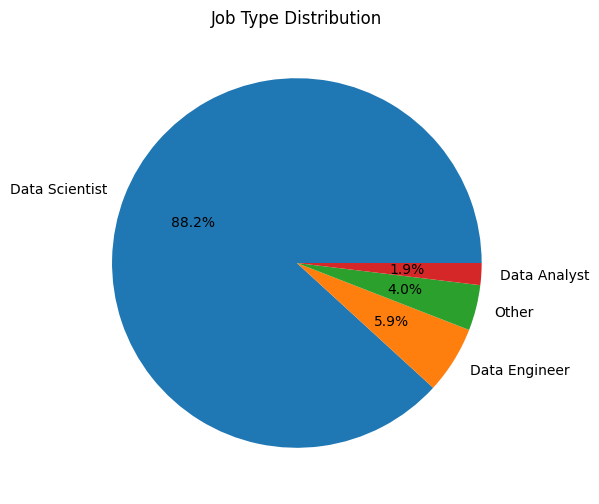

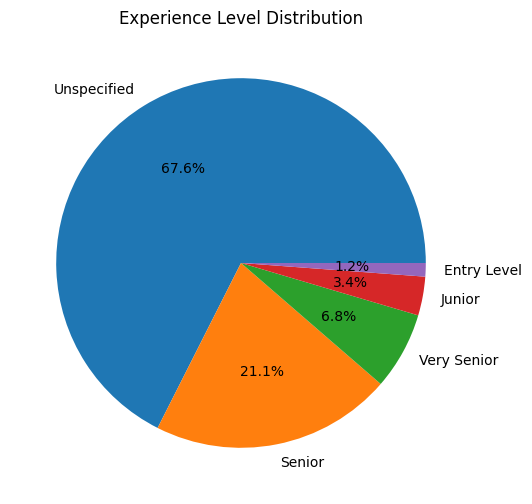

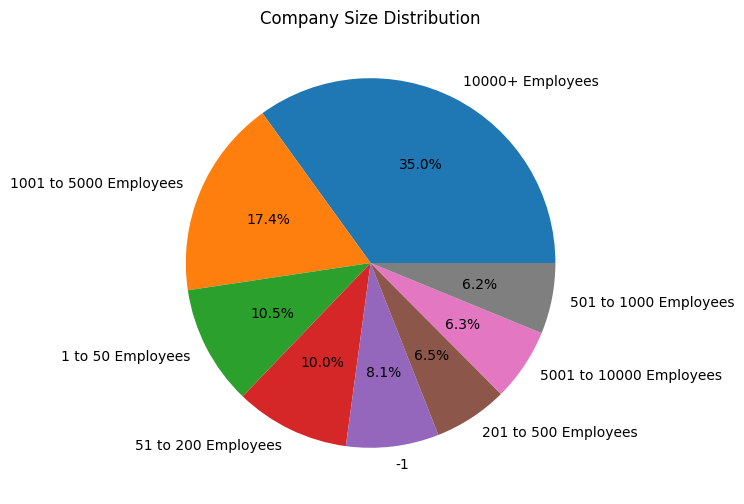

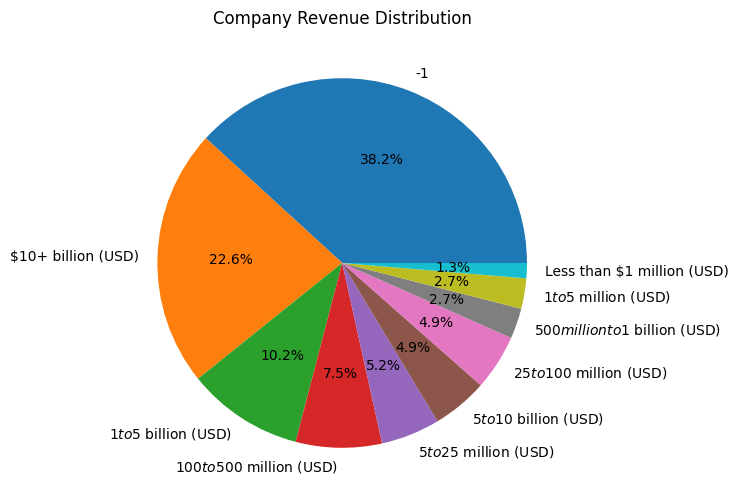

In [170]:
value_counts = df['Job Type'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%')
plt.title('Job Type Distribution')
plt.show()

value_counts = df['Experience Level'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%')
plt.title('Experience Level Distribution')
plt.show()

value_counts = df['Size'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%')
plt.title('Company Size Distribution')
plt.show()

value_counts = df['Revenue'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%')
plt.title('Company Revenue Distribution')
plt.show()

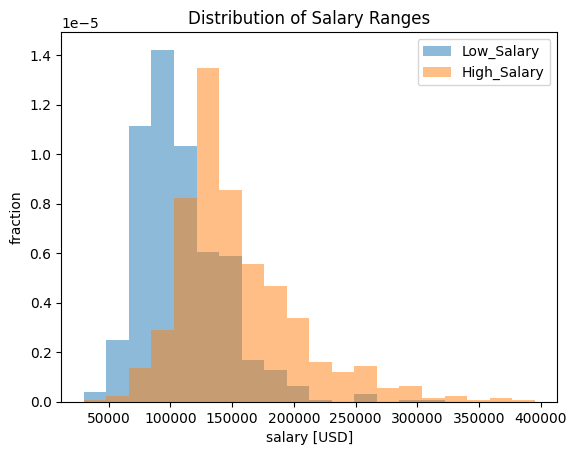

In [171]:
from matplotlib import pylab as plt

categories = ['Low_Salary', 'High_Salary']
bin_range = (df['Low_Salary'].min(),df['High_Salary'].max())

# plt.figure(figsize=(5,3))

for c in categories:
    plt.hist(df[c],alpha=0.5,label=c,range=bin_range,bins=20,density=True)
plt.legend()
plt.ylabel('fraction')
plt.xlabel('salary [USD]')
plt.title('Distribution of Salary Ranges')
plt.show()

In [172]:
# Get number of distinct companies
print(df['Company Name'].nunique())

# Get number of distinct locations
print(df['Location'].nunique())

551
251


It looks like we have a lot of companies represented in our sample.
We also have a lot of distinct locations, so creation of a new 'State' column
will help link similar locations together.

In [173]:
# Drop columns that are not useful for our analysis
df.drop(['Job Title', 'Salary Estimate', 'Job Description', 'Low_Salary', 'High_Salary'], axis=1, inplace=True)

# # Drop continuous columns with many missing values and weak correlation with target
# df.drop(['Rating', 'Founded'], axis=1, inplace=True)

In [174]:
df.head(5)

,Rating,Company Name,Location,Size,Founded,Type of ownership,Industry,Sector,Revenue,State,Avg_Salary,Job Type,Experience Level,Python,R,SQL,AI
0,4.4,Adobe,"San Jose, CA",10000+ Employees,1982,Company - Public,Computer Hardware Development,Information Technology,$5 to $10 billion (USD),CA,118000.0,Data Scientist,Unspecified,1,1,1,0
1,3.9,IBM,"Atlanta, GA",10000+ Employees,1911,Company - Public,Information Technology Support Services,Information Technology,$10+ billion (USD),GA,102000.0,Data Scientist,Entry Level,0,0,0,1
2,4.3,Microsoft,"Redmond, WA",10000+ Employees,1975,Company - Public,Computer Hardware Development,Information Technology,$10+ billion (USD),WA,138500.0,Data Scientist,Unspecified,0,0,0,0
3,3.9,CPChem,"The Woodlands, TX",1001 to 5000 Employees,2000,Company - Private,Chemical Manufacturing,Manufacturing,$10+ billion (USD),TX,63000.0,Data Scientist,Entry Level,0,0,0,0
4,-1.0,IVID TEK INC,Remote,1 to 50 Employees,-1,Company - Public,-1,-1,-1,Remote,145600.0,Data Scientist,Unspecified,0,0,0,1


# Note to TAs:
You can skip ahead to the section titled "Putting it all together FINAL" at the very end to see
where
I combine all of these splitting and preprocessing steps.

Split the data

In [175]:
# Drop all salary columns and use group splitting. Use 'avg' for simplicity, but make note that this can be swapped for either 'low' or 'high'

# 60/20/20 train/val/test split

from sklearn.model_selection import GroupShuffleSplit

random_state = 42 # ensures reproducibility

# separate the feature matrix X, and target variable y
y = df['Avg_Salary']
X = df.loc[:, df.columns != 'Avg_Salary']

groups = df['Company Name']
gss = GroupShuffleSplit(n_splits=5, train_size=0.6, random_state=random_state)

count = 0
for train_idx, other_idx in gss.split(X, y, groups):
    X_train = np.array(X)[train_idx]
    y_train = np.array(y)[train_idx]
    X_other = np.array(X)[other_idx]
    y_other = np.array(y)[other_idx]
    second_split_groups = np.array(np.array(groups)[other_idx])
    gss = GroupShuffleSplit(n_splits=1, train_size=0.5, random_state=random_state)
    for val_idx, test_idx in gss.split(X_other, y_other, second_split_groups):
        X_val, y_val = np.array(X)[val_idx], np.array(y)[val_idx]
        X_test, y_test = np.array(X)[test_idx], np.array(y)[test_idx]
    count += 1
    X_train = pd.DataFrame(X_train, columns=X.columns)
    X_val = pd.DataFrame(X_val, columns=X.columns)
    X_test = pd.DataFrame(X_test, columns=X.columns)
    print('Split ' + str(count) + ':')
    print("Train set size:", len(train_idx))
    print("Validation set size", len(val_idx))
    print("Test set size", len(test_idx))

Split 1:
Train set size: 397
Validation set size 142
Test set size 139
Split 2:
Train set size: 404
Validation set size 132
Test set size 142
Split 3:
Train set size: 403
Validation set size 142
Test set size 133
Split 4:
Train set size: 410
Validation set size 133
Test set size 135
Split 5:
Train set size: 402
Validation set size 137
Test set size 139


### One-Hot Encoding Categorical Features

In [176]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

# let's collect all categorical features first
onehot_ftrs = ['Company Name', 'Location', 'State', 'Type of ownership', 'Industry', 'Job Type']
# initialize the encoder
enc = OneHotEncoder(sparse=False,handle_unknown='ignore') # by default, OneHotEncoder returns a sparse matrix. sparse=False returns a 2D array
# fit the training data
enc.fit(X_train[onehot_ftrs])
print('feature names:',enc.get_feature_names_out(onehot_ftrs))
print(len(enc.get_feature_names_out(onehot_ftrs)))

feature names: ['Company Name_ABBVIE' 'Company Name_ADM Associates'
 'Company Name_AG Grace Inc' 'Company Name_AKASA'
 'Company Name_APPIC Solutions LLC' 'Company Name_AT&T'
 'Company Name_Abbott Laboratories' 'Company Name_Abrigo'
 'Company Name_Aderas, Inc'
 'Company Name_Advanced Technology and Research Corporation'
 'Company Name_Afterpay' 'Company Name_Albertsons Companies'
 'Company Name_Ally Financial' 'Company Name_Alpha Facilities Solutions'
 'Company Name_Altria' 'Company Name_Amazon Web Services, Inc.'
 'Company Name_Amazon.com Services LLC' 'Company Name_Americo'
 'Company Name_Ancestry' 'Company Name_Applanix'
 'Company Name_AppsIntegration.Inc' 'Company Name_Arcfield'
 'Company Name_Arch Systems, LLC' 'Company Name_Ascension'
 'Company Name_Assertive Professionals' 'Company Name_Atlassian'
 'Company Name_Atto Trading' 'Company Name_Axle Informatics'
 'Company Name_Azurity Pharmaceuticals' 'Company Name_BICP'
 'Company Name_BOEING' 'Company Name_BTAS'
 'Company Name_BTS So

In [177]:
# transform X_train
onehot_train = enc.transform(X_train[onehot_ftrs])
print('transformed train features:')
print(onehot_train)
# transform X_val
onehot_val = enc.transform(X_val[onehot_ftrs])
print('transformed val features:')
print(onehot_val)
# transform X_test
onehot_test = enc.transform(X_test[onehot_ftrs])
print('transformed test features:')
print(onehot_test)

transformed train features:
[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
transformed val features:
[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
transformed test features:
[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


### Ordinal encoding for ordinal features

In [178]:
# get categories for each ordinal feature
ordinal_ftrs = ['Size', 'Revenue', 'Experience Level']
for ftr in ordinal_ftrs:
  print(ftr, 'categories:')
  print(df[ftr].value_counts())
  print('')

Size categories:
10000+ Employees           237
1001 to 5000 Employees     118
1 to 50 Employees           71
51 to 200 Employees         68
-1                          55
201 to 500 Employees        44
5001 to 10000 Employees     43
501 to 1000 Employees       42
Name: Size, dtype: int64

Revenue categories:
-1                                  259
$10+ billion (USD)                  153
$1 to $5 billion (USD)               69
$100 to $500 million (USD)           51
$5 to $25 million (USD)              35
$5 to $10 billion (USD)              33
$25 to $100 million (USD)            33
$500 million to $1 billion (USD)     18
$1 to $5 million (USD)               18
Less than $1 million (USD)            9
Name: Revenue, dtype: int64

Experience Level categories:
Unspecified    458
Senior         143
Very Senior     46
Junior          23
Entry Level      8
Name: Experience Level, dtype: int64



In [179]:
# initialize the encoder
ordinal_ftrs = ['Size', 'Revenue', 'Experience Level'] # if you have more than one ordinal feature, add the feature names here
ordinal_cats = [['-1', '1 to 50 Employees', '51 to 200 Employees', '201 to 500 Employees',
                 '501 to 1000 Employees', '1001 to 5000 Employees', '5001 to 10000 Employees',
                 '10000+ Employees'],
 ['-1', 'Less than $1 million (USD)', '$1 to $5 million (USD)', '$5 to $25 million (USD)',
  '$25 to $100 million (USD)', '$100 to $500 million (USD)',
  '$500 million to $1 billion (USD)', '$1 to $5 billion (USD)',
  '$5 to $10 billion (USD)', '$10+ billion (USD)'],
  ['Entry Level', 'Junior', 'Unspecified', 'Senior', 'Very Senior']]
# ordinal_cats must contain one list per ordinal feature! each list contains the ordered list of categories
# of the corresponding feature

enc = OrdinalEncoder(categories = ordinal_cats)   # By default, the categories are alphabetically ordered
                                                    # which is NOT what you want usually.

# fit the training data
enc.fit(X_train[ordinal_ftrs])  # the encoder expects a 2D array, that's why the column name is in a list

# transform X_train. We could use enc.fit_transform(X_train) to combine fit and transform
ordinal_train = enc.transform(X_train[ordinal_ftrs])
print('transformed train features:')
print(ordinal_train)
# transform X_val
ordinal_val = enc.transform(X_val[ordinal_ftrs])
print('transformed validation features:')
print(ordinal_val)
# transform X_test
ordinal_test = enc.transform(X_test[ordinal_ftrs])
print('transformed test features:')
print(ordinal_test)

transformed train features:
[[7. 9. 0.]
 [5. 9. 0.]
 [7. 9. 3.]
 ...
 [1. 0. 2.]
 [7. 9. 2.]
 [7. 0. 2.]]
transformed validation features:
[[7. 8. 2.]
 [7. 9. 2.]
 [5. 9. 0.]
 [1. 0. 2.]
 [7. 9. 3.]
 [7. 0. 2.]
 [7. 9. 2.]
 [5. 4. 2.]
 [7. 8. 1.]
 [7. 9. 0.]
 [7. 3. 2.]
 [7. 9. 2.]
 [5. 5. 2.]
 [4. 0. 2.]
 [5. 7. 2.]
 [2. 3. 2.]
 [0. 0. 2.]
 [5. 7. 2.]
 [2. 0. 2.]
 [5. 5. 2.]
 [5. 5. 2.]
 [0. 0. 2.]
 [3. 4. 2.]
 [2. 0. 2.]
 [3. 4. 2.]
 [1. 2. 2.]
 [7. 9. 2.]
 [7. 9. 2.]
 [5. 7. 2.]
 [1. 0. 2.]
 [1. 0. 2.]
 [0. 0. 2.]
 [7. 9. 0.]
 [7. 4. 2.]
 [5. 0. 2.]
 [0. 0. 2.]
 [7. 2. 2.]
 [7. 9. 2.]
 [4. 5. 2.]
 [5. 7. 2.]
 [2. 3. 2.]
 [1. 3. 1.]
 [7. 9. 2.]
 [7. 9. 2.]
 [1. 0. 2.]
 [0. 0. 2.]
 [7. 9. 2.]
 [2. 0. 2.]
 [6. 7. 2.]
 [3. 4. 1.]
 [0. 0. 1.]
 [2. 3. 1.]
 [1. 0. 2.]
 [7. 0. 2.]
 [6. 0. 1.]
 [3. 4. 2.]
 [1. 0. 2.]
 [7. 0. 2.]
 [7. 9. 2.]
 [7. 7. 2.]
 [7. 9. 2.]
 [5. 7. 2.]
 [1. 0. 2.]
 [7. 9. 0.]
 [2. 0. 2.]
 [0. 0. 2.]
 [4. 0. 2.]
 [2. 4. 1.]
 [7. 8. 0.]
 [5. 0. 2.]
 [3. 1. 2.]
 [5. 9. 2

In [180]:
# Scale our only continuous feature (Avg_Salary)
scaler = StandardScaler()
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1,1))
y_val_scaled = scaler.transform(np.array(y_val).reshape(-1,1))
y_test_scaled = scaler.transform(np.array(y_test).reshape(-1,1))

y_train = y_train_scaled.flatten()
y_val = y_val_scaled.flatten()
y_test = y_test_scaled.flatten()

In [181]:
# Produce our final train, val, test sets
# We dropped our continuous features so we don't see them here
X_train = np.concatenate((onehot_train, ordinal_train), axis=1)
X_val = np.concatenate((onehot_val, ordinal_val), axis=1)
X_test = np.concatenate((onehot_test, ordinal_test), axis=1)

print(X_train.shape, X_val.shape, X_test.shape)
X_train[:5], X_val[:5], X_test[:5]

(402, 632) (137, 632) (139, 632)


(array([[0., 0., 0., ..., 7., 9., 0.],
        [0., 0., 0., ..., 5., 9., 0.],
        [0., 0., 0., ..., 7., 9., 3.],
        [0., 0., 0., ..., 7., 0., 2.],
        [0., 0., 0., ..., 5., 4., 2.]]),
 array([[0., 0., 0., ..., 7., 8., 2.],
        [0., 0., 0., ..., 7., 9., 2.],
        [0., 0., 0., ..., 5., 9., 0.],
        [0., 0., 0., ..., 1., 0., 2.],
        [0., 0., 0., ..., 7., 9., 3.]]),
 array([[0., 0., 0., ..., 7., 9., 0.],
        [0., 0., 0., ..., 1., 0., 2.],
        [0., 0., 0., ..., 3., 4., 2.],
        [0., 0., 0., ..., 5., 6., 2.],
        [0., 0., 0., ..., 7., 9., 2.]]))

In [182]:
# Put everything together so we return train/val/test sets for each fold
random_state = 42 # ensures reproducibility

onehot_ftrs = ['Company Name', 'Location', 'State', 'Type of ownership', 'Industry', 'Job Type']
ordinal_ftrs = ['Size', 'Revenue', 'Experience Level']
ordinal_cats = [['-1', '1 to 50 Employees', '51 to 200 Employees', '201 to 500 Employees',
                    '501 to 1000 Employees', '1001 to 5000 Employees', '5001 to 10000 Employees',
                    '10000+ Employees'],
    ['-1', 'Less than $1 million (USD)', '$1 to $5 million (USD)', '$5 to $25 million (USD)',
    '$25 to $100 million (USD)', '$100 to $500 million (USD)',
    '$500 million to $1 billion (USD)', '$1 to $5 billion (USD)',
    '$5 to $10 billion (USD)', '$10+ billion (USD)'],
    ['Entry Level', 'Junior', 'Unspecified', 'Senior', 'Very Senior']]

# separate the feature matrix X, and target variable y
y = df['Avg_Salary']
X = df.loc[:, df.columns != 'Avg_Salary']

groups = df['Company Name']
gss = GroupShuffleSplit(n_splits=5, train_size=0.6, random_state=random_state)

for train_idx, other_idx in gss.split(X, y, groups):
    X_train = np.array(X)[train_idx]
    y_train = np.array(y)[train_idx]
    X_other = np.array(X)[other_idx]
    y_other = np.array(y)[other_idx]
    second_split_groups = np.array(np.array(groups)[other_idx])
    gss = GroupShuffleSplit(n_splits=1, train_size=0.5, random_state=random_state)
    for val_idx, test_idx in gss.split(X_other, y_other, second_split_groups):
        X_val, y_val = np.array(X)[val_idx], np.array(y)[val_idx]
        X_test, y_test = np.array(X)[test_idx], np.array(y)[test_idx]
    X_train = pd.DataFrame(X_train, columns=X.columns)
    X_val = pd.DataFrame(X_val, columns=X.columns)
    X_test = pd.DataFrame(X_test, columns=X.columns)

    # initialize the encoder
    enc = OneHotEncoder(sparse=False,handle_unknown='ignore')
    # fit the training data
    enc.fit(X_train[onehot_ftrs])
    # transform X_train
    onehot_train = enc.transform(X_train[onehot_ftrs])
    # transform X_val
    onehot_val = enc.transform(X_val[onehot_ftrs])
    # transform X_test
    onehot_test = enc.transform(X_test[onehot_ftrs])
    # initialize the encoder
    enc = OrdinalEncoder(categories = ordinal_cats)
    # fit the training data
    enc.fit(X_train[ordinal_ftrs])
    # transform X_train. We could use enc.fit_transform(X_train) to combine fit and transform
    ordinal_train = enc.transform(X_train[ordinal_ftrs])
    # transform X_val
    ordinal_val = enc.transform(X_val[ordinal_ftrs])
    # transform X_test
    ordinal_test = enc.transform(X_test[ordinal_ftrs])
    # concatenate results of encoders
    X_train = np.concatenate((onehot_train, ordinal_train), axis=1)
    X_val = np.concatenate((onehot_val, ordinal_val), axis=1)
    X_test = np.concatenate((onehot_test, ordinal_test), axis=1)
    # normalize labels
    scaler = StandardScaler()
    y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1,1))
    y_val_scaled = scaler.transform(np.array(y_val).reshape(-1,1))
    y_test_scaled = scaler.transform(np.array(y_test).reshape(-1,1))
    y_train = y_train_scaled.flatten()
    y_val = y_val_scaled.flatten()
    y_test = y_test_scaled.flatten()
        

<AxesSubplot: >

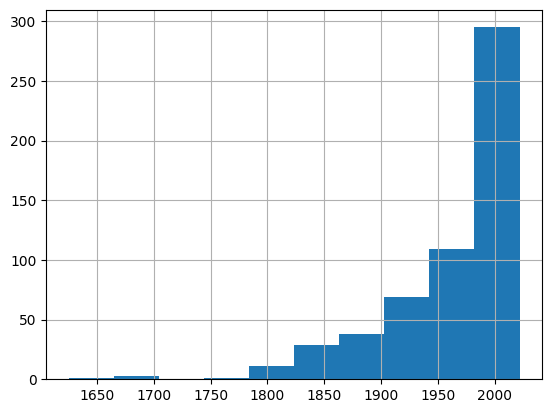

In [183]:
df[df['Founded'] != -1]['Founded'].hist()

Putting it all together **FINAL**

In [184]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
random_state = 42 # ensures reproducibility

onehot_ftrs = ['Company Name', 'Location', 'State', 'Type of ownership', 'Industry', 'Job Type']
ordinal_ftrs = ['Size', 'Revenue', 'Experience Level']
ordinal_cats = [['-1', '1 to 50 Employees', '51 to 200 Employees', '201 to 500 Employees',
                    '501 to 1000 Employees', '1001 to 5000 Employees', '5001 to 10000 Employees',
                    '10000+ Employees'],
    ['-1', 'Less than $1 million (USD)', '$1 to $5 million (USD)', '$5 to $25 million (USD)',
    '$25 to $100 million (USD)', '$100 to $500 million (USD)',
    '$500 million to $1 billion (USD)', '$1 to $5 billion (USD)',
    '$5 to $10 billion (USD)', '$10+ billion (USD)'],
    ['Entry Level', 'Junior', 'Unspecified', 'Senior', 'Very Senior']]
minmax_ftrs = ['Rating', 'Python', 'R', 'SQL', 'AI']
std_ftrs = ['Founded']

# separate the feature matrix X, and target variable y
y = df['Avg_Salary']
X = df.loc[:, df.columns != 'Avg_Salary']

groups = df['Company Name']
gss = GroupShuffleSplit(n_splits=5, train_size=0.6, random_state=random_state)

for train_idx, other_idx in gss.split(X, y, groups):
    X_train = np.array(X)[train_idx]
    y_train = np.array(y)[train_idx]
    X_other = np.array(X)[other_idx]
    y_other = np.array(y)[other_idx]
    second_split_groups = np.array(np.array(groups)[other_idx])
    gss = GroupShuffleSplit(n_splits=1, train_size=0.5, random_state=random_state)
    for val_idx, test_idx in gss.split(X_other, y_other, second_split_groups):
        X_val, y_val = np.array(X)[val_idx], np.array(y)[val_idx]
        X_test, y_test = np.array(X)[test_idx], np.array(y)[test_idx]
    X_train = pd.DataFrame(X_train, columns=X.columns)
    X_val = pd.DataFrame(X_val, columns=X.columns)
    X_test = pd.DataFrame(X_test, columns=X.columns)

    # normalize labels
    label_scaler = StandardScaler()
    y_train_scaled = label_scaler.fit_transform(np.array(y_train).reshape(-1,1))
    y_val_scaled = label_scaler.transform(np.array(y_val).reshape(-1,1))
    y_test_scaled = label_scaler.transform(np.array(y_test).reshape(-1,1))
    y_train = y_train_scaled.flatten()
    y_val = y_val_scaled.flatten()
    y_test = y_test_scaled.flatten()

    # collect all the encoders
    preprocessor = ColumnTransformer(
        transformers=[
            ('ord', OrdinalEncoder(categories = ordinal_cats), ordinal_ftrs),
            ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'), onehot_ftrs),
            ('minmax', MinMaxScaler(), minmax_ftrs),
            ('std', StandardScaler(), std_ftrs)])

    clf = Pipeline(steps=[('preprocessor', preprocessor)]) # for now we only preprocess 
                                                        # later on we will add other steps here

    X_train_prep = clf.fit_transform(X_train)
    X_val_prep = clf.transform(X_val)
    X_test_prep = clf.transform(X_test)

    # Get shapes
    print(X_train_prep.shape)
    print(X_val_prep.shape)
    print(X_test_prep.shape)
    print('')
    

(397, 619)
(142, 619)
(139, 619)

(404, 627)
(132, 627)
(142, 627)

(403, 624)
(142, 624)
(133, 624)

(410, 631)
(133, 631)
(135, 631)

(402, 638)
(137, 638)
(139, 638)

